# Sentiment Analysis 

Let's go back to our sentiment analysis but this time we will use Spacy for our pre-processing and see if we can improve our performance.  

## Data Preprocessing

### Import Data

1. Import the following libraries:

* tensorflow
* matplotlib
* pandas 
* numpy

In [13]:
import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

2. Copy the link below and read the file it contains with `pandas`.

* https://go.aws/314bBDq

In [2]:
dataset = pd.read_csv("https://go.aws/314bBDq", error_bad_lines=False)
dataset.head()

,user_id,review,stars,date_format,time_of_day,hour_of_day,day_of_week,review_format,review_lang,month_year,review_len,review_nb_words
0,efb62a167fee5cf3678b24427de8e31f,"Génial, fabuleux, exceptionnel ! J'aimerais qu...",5,2017-09-29 18:17:00,18:17,18,Ven,génial fabuleux exceptionnel j aimerais qu...,french,2017-09,115,19
1,e3be4f9c9e0b9572bfb2a5f88497bb14,NaN,2,2017-09-29 17:29:00,17:29,17,Ven,NaN,NaN,2017-09,0,0
2,1b8e5760162d867e9b9ca80f645bdc60,"Toujours aussi magic, féerique !",5,2017-09-29 16:46:00,16:46,16,Ven,toujours aussi magic féerique,french,2017-09,32,4
3,fa330e5891a1bb486c3e9bf95c098726,NaN,5,2017-09-29 15:52:00,15:52,15,Ven,NaN,NaN,2017-09,0,0
4,c1a693206aee1a2412d4bd9e45b80ec5,NaN,3,2017-09-29 15:29:00,15:29,15,Ven,NaN,NaN,2017-09,0,0


3. We will need the reviews in French. Filter the reviews so that they are in the right language. 

In [3]:
# Taking only french reviews
french_reviews = dataset[dataset["review_lang"] == "french"]
french_reviews.head()

,user_id,review,stars,date_format,time_of_day,hour_of_day,day_of_week,review_format,review_lang,month_year,review_len,review_nb_words
0,efb62a167fee5cf3678b24427de8e31f,"Génial, fabuleux, exceptionnel ! J'aimerais qu...",5,2017-09-29 18:17:00,18:17,18,Ven,génial fabuleux exceptionnel j aimerais qu...,french,2017-09,115,19
2,1b8e5760162d867e9b9ca80f645bdc60,"Toujours aussi magic, féerique !",5,2017-09-29 16:46:00,16:46,16,Ven,toujours aussi magic féerique,french,2017-09,32,4
11,726b1a3e2664e8b075129bcd643dbf56,En vacances en région parisienne nous nous som...,2,2017-09-29 00:37:00,00:37,0,Ven,en vacances en région parisienne nous nous som...,french,2017-09,172,25
12,8a71763fbb3da7436b957681b24cc404,Tropbeaufinalpleinlesyeuxoreil,5,2017-09-29 00:16:00,00:16,0,Ven,tropbeaufinalpleinlesyeuxoreil,french,2017-09,30,1
23,ce7abd7798ee036d667c0ad84b85daa7,L'univers Disney reste merveilleux. Toutefois ...,4,2017-09-28 20:24:00,20:24,20,Jeu,l univers disney reste merveilleux toutefois ...,french,2017-09,148,23


4. Keep only the `review_format` & `stars` columns.

In [4]:
# Let's take the columns we're interested in 
french_reviews = french_reviews[["review_format", "stars"]]
french_reviews.head()

,review_format,stars
0,génial fabuleux exceptionnel j aimerais qu...,5
2,toujours aussi magic féerique,5
11,en vacances en région parisienne nous nous som...,2
12,tropbeaufinalpleinlesyeuxoreil,5
23,l univers disney reste merveilleux toutefois ...,4


5. Remove missing values

In [5]:
# Deleting NaN
french_reviews = french_reviews.dropna()

6. Look at the unique values for each of the stars 

In [6]:
# Valeurs uniques
french_reviews["stars"].unique()

array([5, 2, 4, 3, 1])

7. Look at the `shape` of your database

In [7]:
french_reviews.shape

(8474, 2)

### Tokenize

We will now go through a Tokenation phase. In other words, we will assign a number to each word in our text corpus. 

* Use the command: `!python -m spacy download fr_core_news_sm` to download all language elements related to the French language

In [8]:
!python -m spacy download fr_core_news_sm

     |████████████████████████████████| 14.7MB 14.4MB/s 
  Created wheel for fr-core-news-sm: filename=fr_core_news_sm-2.2.5-cp37-none-any.whl size=14727027 sha256=210bac0ac8bc20d31974b87c1bb04056a9b9bc4f551c2d60b04884002a2664f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-8k4_eeod/wheels/46/1b/e6/29b020e3f9420a24c3f463343afe5136aaaf955dbc9e46dfc5
Successfully built fr-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


* Load now `fr_core_news_sm`

In [9]:
# Import Spacy and french initialisation
import fr_core_news_sm
nlp = fr_core_news_sm.load()

* Import french STOP_WORDS

In [10]:
# Import Stop words 
from spacy.lang.fr.stop_words import STOP_WORDS

* You will now have to clean our texts in order to prepare them for training. Using spacy, replace all tokens in your texts with lemma_ and remove all the stop words.

In [11]:
french_reviews["review_format_clean"] = french_reviews["review_format"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if token.lemma_ not in STOP_WORDS]))
french_reviews

,review_format,stars,review_format_clean
0,génial fabuleux exceptionnel j aimerais qu...,5,génial fabuleu exceptionnel j aimerai w...
2,toujours aussi magic féerique,5,magic féerique
11,en vacances en région parisienne nous nous som...,2,vacance région parisien décider visiter parc r...
12,tropbeaufinalpleinlesyeuxoreil,5,tropbeaufinalpleinlesyeuxoreil
23,l univers disney reste merveilleux toutefois ...,4,l univers disney merveilleux regrette qu fal...
...,...,...,...
295057,toujours aussi magique même si à la fin du séj...,5,magique fin séjour rotule lol
295549,séjour au top mes enfants les plus heureux ...,5,séjour top enfant heureux vouloir voir per...
298475,magnifique un monde parfait lt,5,magnifique monde parfaire lt
298832,oui j ai aimé car j adore disney et tout ce qu...,4,oui j aimer j adore disney touche univers ...


* Using `tf.keras.preprocessing.text.Tokenizer`, process to encoding all the reviews (be careful, some reviews might have been entirely erased, try and understand why, remove those reviews)

In [15]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(french_reviews.review_format_clean)
french_reviews["review_encoded"] = tokenizer.texts_to_sequences(french_reviews.review_format_clean)
french_reviews["len_review"] = french_reviews["review_encoded"].apply(lambda x: len(x))
french_reviews = french_reviews[french_reviews["len_review"]!=0]

* Try and convert your texts and labels into a tensor slice dataset (it should fail giving this error:   
`ValueError: Failed to convert a Numpy array to a Tensor (Unsupported object type list)`.)

In [16]:
full_ds = tf.data.Dataset.from_tensor_slices((french_reviews.review_encoded, french_reviews.stars.values - 1))

ValueError: ignored

* This is perfectly normal, TensorFlow is incapable as of now to create a tensor dataset based on lists, we will have to store all of our encoded texts into a single numpy array before creating the tensorflow dataset. The problem is that not all our sequences are the same length, this is where the `tf.keras.preprocessing.sequence.pad_sequences` comes in handy, it will add zero padding at the beginning (`padding="pre"`) or at the end (`padding="post"`) of your sequences so they all have equal length.

In [17]:
reviews_pad = tf.keras.preprocessing.sequence.pad_sequences(french_reviews.review_encoded, padding="post")

* Now that your sequences are padded create the tensor dataset

In [18]:
full_ds = tf.data.Dataset.from_tensor_slices((reviews_pad, french_reviews.stars.values - 1))

* Do a train / test split of your data (keep about 70% in the train)

In [20]:
# Train Test Split
n_reviews = len(french_reviews)
TAKE_SIZE = int(0.7 * n_reviews)

train_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE).batch(16)
test_data = full_ds.skip(TAKE_SIZE).shuffle(n_reviews - TAKE_SIZE).batch(16)

* Look at a batch of data 

In [22]:
for review, star in train_data.take(1):
    print(review, star)

tf.Tensor(
[[  25  553 1734 ...    0    0    0]
 [   5   41   24 ...    0    0    0]
 [  10   23  106 ...    0    0    0]
 ...
 [ 112   43   37 ...    0    0    0]
 [   5  146   69 ...    0    0    0]
 [  77   79  106 ...    0    0    0]], shape=(16, 241), dtype=int32) tf.Tensor([4 3 4 4 3 4 1 2 4 4 4 3 2 3 4 4], shape=(16,), dtype=int64)


## Modeling

1. Create a model with the architecture below

In [23]:
model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, 64, input_shape=[review.shape[1],]),

                  # Couche CNN
                  tf.keras.layers.Conv1D(16, 3, activation="relu"),

                  # Flatten
                  tf.keras.layers.Flatten(),         

                  # Couche Dense classique 
                  tf.keras.layers.Dense(64, activation='relu'),
                  tf.keras.layers.Dense(32, activation='relu'),
                  tf.keras.layers.Dense(16, activation='relu'),
                  tf.keras.layers.Dense(8, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(5, activation="softmax")                                 
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 241, 64)           661632    
_________________________________________________________________
conv1d (Conv1D)              (None, 239, 16)           3088      
_________________________________________________________________
flatten (Flatten)            (None, 3824)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                244800    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 1

2. Create a `learning_rate_schedule` and compile your model with the correct cost function. 

In [25]:
# Créons un learning rate schedule pour décroitre le learning rate à mesure que nous entrainons le modèle 
initial_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=2500,
    decay_rate=0.96,
    staircase=True)

# Utilisation d'un compileur simple avec un optimiseur Adam pour le calcul de nos gradients 
optimizer= tf.keras.optimizers.Adam(
    learning_rate = lr_schedule
)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

3. Fit your model on 10 epochs with weights to penalize too frequent notes. 

In [26]:
# Balance des classes
class_weight = {
    0:2,
    1:2,
    2:1,
    3:0.75,
    4:0.5
}

In [27]:
# Entrainement du modèle 
history = model.fit(train_data, 
                    epochs=10, 
                    validation_data=test_data,
                    class_weight=class_weight)

Epoch 1/10
371/371 [==============================] - 36s 10ms/step - loss: 1.2402 - sparse_categorical_accuracy: 0.5023 - val_loss: 1.2696 - val_sparse_categorical_accuracy: 0.6305
Epoch 2/10
371/371 [==============================] - 3s 9ms/step - loss: 1.1753 - sparse_categorical_accuracy: 0.5510 - val_loss: 0.9213 - val_sparse_categorical_accuracy: 0.6954
Epoch 3/10
371/371 [==============================] - 3s 9ms/step - loss: 1.0353 - sparse_categorical_accuracy: 0.6017 - val_loss: 0.8490 - val_sparse_categorical_accuracy: 0.6978
Epoch 4/10
371/371 [==============================] - 3s 9ms/step - loss: 0.9139 - sparse_categorical_accuracy: 0.6529 - val_loss: 0.8595 - val_sparse_categorical_accuracy: 0.6844
Epoch 5/10
371/371 [==============================] - 3s 9ms/step - loss: 0.8644 - sparse_categorical_accuracy: 0.6685 - val_loss: 1.0194 - val_sparse_categorical_accuracy: 0.6108
Epoch 6/10
371/371 [==============================] - 3s 9ms/step - loss: 0.8286 - sparse_categori

* View an example of prediction on your test data

In [28]:
for example, label in test_data.take(1):
    print(tokenizer.sequences_to_texts(example.numpy())[0])
    print("Prediction : {}".format(np.argmax(model.predict(example)[0], axis=-1)))
    print("Real: {}".format(label[0]))

passer vraiment moment magique l hôtel santa fé superbe sûr revenir l équipe disney
Prediction : 4
Real: 4


## Evaluation 

1. Create a graph showing your loss in relation to the number of epochs.

No handles with labels found to put in legend.


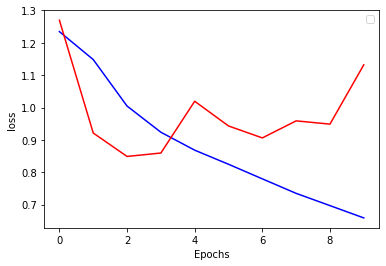

In [29]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

2. Create a graph showing your accuracy in relation to the number of epochs.

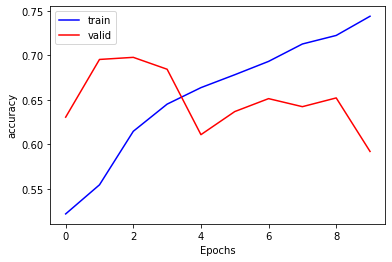

In [30]:
# Visualization of accuracy training 
plt.plot(history.history["sparse_categorical_accuracy"], color="b", label="train")
plt.plot(history.history["val_sparse_categorical_accuracy"], color="r", label="valid")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()